In [2]:
import os
import pandas as pd
import sys
from torch.utils.data import DataLoader as TorchDataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import seaborn as sns

# --- (Recomendado) Recarga automática de módulos ---
%load_ext autoreload
%autoreload 2

# --- Añadir la carpeta raíz al path para encontrar la carpeta 'src' ---
# Ajusta la ruta si es necesario.
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Añadido al path: {project_root}")

# --- IMPORTAMOS NUESTRA ARQUITECTURA DESDE EL ARCHIVO .PY ---
from src.architecture import Dataset, collate_fn, Model, fit

# --- Configuración del Dispositivo ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Usando dispositivo: cuda


In [3]:
# --- Rutas de Datos ---
RAW_DATA_PATH = "../data/raw/color"
PROCESSED_DATA_PATH = "../data/processed/"

# --- Carga de DataFrames ---
df_strat1 = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'train_strategy_1.csv'))
df_strat2 = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'train_strategy_2.csv'))
df_valid_full = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv'))

# --- Preparar DataFrame de Validación ---
df_valid = df_valid_full[df_valid_full['split'] == 'valid'].copy()
df_valid['image_path'] = df_valid['relative_path'].apply(lambda rel_path: os.path.join(RAW_DATA_PATH, rel_path))

# --- Mapeo de Clases y Transformación ---
all_classes = sorted(df_valid_full['class'].unique())
label_map = {label: i for i, label in enumerate(all_classes)}
NUM_CLASSES = len(all_classes)
trans = transforms.Compose([transforms.Resize((224, 224))])
print("Transformación definida: solo Resize a 224x224.")

# --- Crear Datasets y DataLoaders ---
dataset_s1 = Dataset(df_strat1['image_path'].values, df_strat1['class'].values, label_map, trans=trans)
dataset_s2 = Dataset(df_strat2['image_path'].values, df_strat2['class'].values, label_map, trans=trans)
dataset_valid = Dataset(df_valid['image_path'].values, df_valid['class'].values, label_map, trans=trans)

dataloader_s1 = {'train': TorchDataLoader(dataset_s1, batch_size=32, shuffle=True, collate_fn=collate_fn),
                 'valid': TorchDataLoader(dataset_valid, batch_size=64, shuffle=False, collate_fn=collate_fn)}

dataloader_s2 = {'train': TorchDataLoader(dataset_s2, batch_size=32, shuffle=True, collate_fn=collate_fn),
                 'valid': TorchDataLoader(dataset_valid, batch_size=64, shuffle=False, collate_fn=collate_fn)}

print(f"DataLoaders creados. Número de clases: {NUM_CLASSES}")

Transformación definida: solo Resize a 224x224.
DataLoaders creados. Número de clases: 38


In [4]:
# Diccionario para guardar los historiales
results = {}

# Hiperparámetros
EPOCHS_TL = 5      # Épocas para Transfer Learning
EPOCHS_FT = 10     # Épocas para Fine-Tuning
LR_TL = 1e-3       # Learning Rate para Transfer Learning
LR_FT = 1e-4       # Learning Rate para Fine-Tuning
PATIENCE = 3       # Paciencia para Early Stopping

# ===================================================================
# --- Experimento con Estrategia 1 ---
# ===================================================================
print("INICIANDO CICLO DE ENTRENAMIENTO PARA ESTRATEGIA 1")
model_s1 = Model(num_classes=NUM_CLASSES, pretrained=True)

# Fase de Transfer Learning
model_s1.freeze()
history_tl_s1 = fit(model=model_s1, dataloader=dataloader_s1, epochs=EPOCHS_TL, lr=LR_TL, patience=PATIENCE, model_name='Strat1_TL', device=DEVICE)

# Fase de Fine-Tuning
model_s1.unfreeze()
history_ft_s1 = fit(model=model_s1, dataloader=dataloader_s1, epochs=EPOCHS_FT, lr=LR_FT, patience=PATIENCE, model_name='Strat1_FT', device=DEVICE)

# Guardamos el historial combinado
results['Estrategia 1'] = {k: history_tl_s1[k] + history_ft_s1[k] for k in history_tl_s1}


# ===================================================================
# --- Experimento con Estrategia 2 ---
# ===================================================================
print("\n" * 2 + "INICIANDO CICLO DE ENTRENAMIENTO PARA ESTRATEGIA 2")
model_s2 = Model(num_classes=NUM_CLASSES, pretrained=True)

# Fase de Transfer Learning
model_s2.freeze()
history_tl_s2 = fit(model=model_s2, dataloader=dataloader_s2, epochs=EPOCHS_TL, lr=LR_TL, patience=PATIENCE, model_name='Strat2_TL', device=DEVICE)

# Fase de Fine-Tuning
model_s2.unfreeze()
history_ft_s2 = fit(model=model_s2, dataloader=dataloader_s2, epochs=EPOCHS_FT, lr=LR_FT, patience=PATIENCE, model_name='Strat2_FT', device=DEVICE)

# Guardamos el historial combinado
results['Estrategia 2'] = {k: history_tl_s2[k] + history_ft_s2[k] for k in history_tl_s2}



INICIANDO CICLO DE ENTRENAMIENTO PARA ESTRATEGIA 1
Congelando capas convolucionales (Transfer Learning)...

--- Entrenando Strat1_TL por un máximo de 5 epochs (Paciencia: 3) ---


Epoch 1/5 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 1/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TL_best.pth'


Epoch 2/5 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 2/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TL_best.pth'


Epoch 3/5 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 3/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TL_best.pth'


Epoch 4/5 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 4/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TL_best.pth'


Epoch 5/5 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 5/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_TL_best.pth'
Entrenamiento finalizado. Cargando mejor modelo desde 'Strat1_TL_best.pth'
Descongelando todas las capas (Fine-tuning)...

--- Entrenando Strat1_FT por un máximo de 10 epochs (Paciencia: 3) ---


Epoch 1/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 1/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 2/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 2/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 3/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 3/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 4/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 4/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 5/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 5/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 6/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 6/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 7/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 7/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 8/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 8/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 9/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 9/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'


Epoch 10/10 [Train]:   0%|          | 0/2928 [00:00<?, ?it/s]

Epoch 10/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10: Mejora en Val Loss. Guardando mejor modelo en 'Strat1_FT_best.pth'
Entrenamiento finalizado. Cargando mejor modelo desde 'Strat1_FT_best.pth'


INICIANDO CICLO DE ENTRENAMIENTO PARA ESTRATEGIA 2
Congelando capas convolucionales (Transfer Learning)...

--- Entrenando Strat2_TL por un máximo de 5 epochs (Paciencia: 3) ---


Epoch 1/5 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 1/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TL_best.pth'


Epoch 2/5 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 2/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TL_best.pth'


Epoch 3/5 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 3/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TL_best.pth'


Epoch 4/5 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 4/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TL_best.pth'


Epoch 5/5 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 5/5 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_TL_best.pth'
Entrenamiento finalizado. Cargando mejor modelo desde 'Strat2_TL_best.pth'
Descongelando todas las capas (Fine-tuning)...

--- Entrenando Strat2_FT por un máximo de 10 epochs (Paciencia: 3) ---


Epoch 1/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 1/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 2/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 2/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 3/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 3/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 4/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 4/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 5/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 5/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 6/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 6/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 7/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 7/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 8/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 8/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 9/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 9/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'


Epoch 10/10 [Train]:   0%|          | 0/1904 [00:00<?, ?it/s]

Epoch 10/10 [Valid]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10: Mejora en Val Loss. Guardando mejor modelo en 'Strat2_FT_best.pth'
Entrenamiento finalizado. Cargando mejor modelo desde 'Strat2_FT_best.pth'


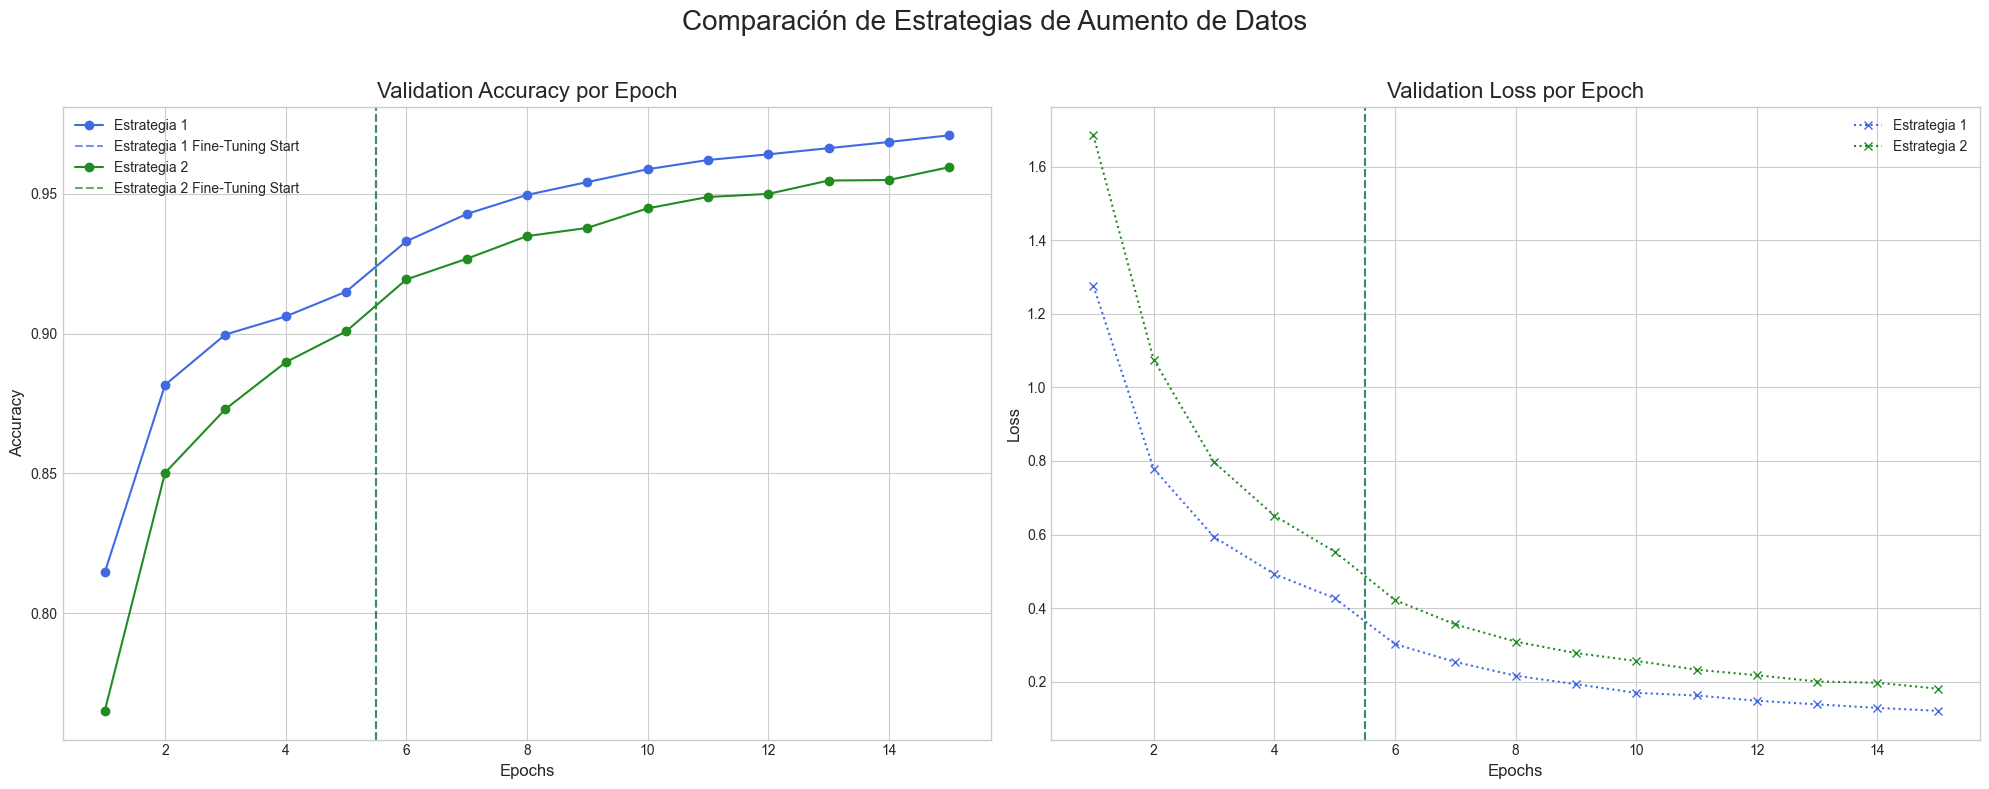

In [5]:
if 'results' in locals() and results:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
    fig.suptitle("Comparación de Estrategias de Aumento de Datos", fontsize=20)

    colors = {'Estrategia 1': 'royalblue', 'Estrategia 2': 'forestgreen'}

    # --- Gráfico de Validation Accuracy ---
    ax = axes[0]
    for name, history in results.items():
        epochs = range(1, len(history['val_acc']) + 1)
        ax.plot(epochs, history['val_acc'], label=name, color=colors[name], marker='o', linestyle='-')
        tl_epochs = len(history_tl_s1.get('val_acc', []))
        if len(epochs) > tl_epochs:
             ax.axvline(x=tl_epochs + 0.5, color=colors[name], linestyle='--', alpha=0.7, label=f'{name} Fine-Tuning Start')

    ax.set_title("Validation Accuracy por Epoch", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.legend()
    ax.grid(True)

    # --- Gráfico de Validation Loss ---
    ax = axes[1]
    for name, history in results.items():
        epochs = range(1, len(history['val_loss']) + 1)
        ax.plot(epochs, history['val_loss'], label=name, color=colors[name], marker='x', linestyle=':')
        tl_epochs = len(history_tl_s1.get('val_loss', []))
        if len(epochs) > tl_epochs:
             ax.axvline(x=tl_epochs + 0.5, color=colors[name], linestyle='--', alpha=0.7)

    ax.set_title("Validation Loss por Epoch", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.legend()
    ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("La variable 'results' no contiene datos. Asegúrate de ejecutar la celda de entrenamiento primero.")
    